In [10]:
from scipy import sparse
from scipy.stats import uniform
from array import array
import numpy as np
import random

import numpy as np, random, operator, pandas as pd, matplotlib.pyplot as plt

In [11]:
# Purpose: Genrate the traveling cost matrix for one salesman
#          This includes the distance between any node and the depot
#          Any none-feasible connection between two nodes is indicated by a large distance: 
#          InfeasibleD

# Inputs:  n -- number of nodes, excludes the depot
#          InfeasibleD -- cost for traveling alone the wrong direction of one-way streets
#          NumOneWay -- number of one-way streets

# Outputs: distance

def TravelCostMatrix(n=10, InfeasibleD=5000, NumOneWay=3):

    # TRAVELING Distance of any node to itself
    SelfD=0

    # Initialize a random square matrix
    # This matrix will go through the following steps to become the TRAVELING distanec matrix 
    # for our n-node, 1-salesmen problem
    np.random.seed(2)
    # We add a row/col to represent the TRAVELING distance between the depot and any node.
    b=np.random.randint(0,30,size=(n+1,n+1))

    # Step 1 -- the initial, unmodified, unextended traveling cost matrix
    #           Make it symmetrical
    distance = (b+b.T)/2

    # Step2 -- Modified unextended traveling cost matrix
    #          randomly assign a few one-way street/infeasible connection 
    #          by making the distance between two random nodes much bigger 
    #          than the distance for feasible connections

    for i in range(NumOneWay):
        np.random.seed(10)
        c=random.sample(range(1,len(distance)), 2)
        distance[c[0],c[1]]=InfeasibleD
        print("We added the largeNum to " + str(c))

    # Step3 -- No traveling cost from any node to itself
    np.fill_diagonal(distance,SelfD)

    return distance

In [12]:
# Purpose: Extend the Travel Cost Matrix for 1 salesman to (m>1) salesman 

# Input:   TravelCost (matrix), 
#          m = the number of salesman, LargeNum = approxi of infinity

# Output:  TotalCost (matrix), 
#          where the TravelCost matrix is extended (m-1) rows and (m-1) cols

def TravelCostMatrix_m(TravelCost, m=1, LargeNum=5000):

    # From this point on, we turn it into a function
    ###########################################################
    if m>1:
        # Step 4   -- Extend the distance matrix for 1-salesmen to m-salesmen
        # Step 4.1 -- Repeat the first rows of the distance m-1 times
        for i in range(m-1):
            TravelCost = np.append(TravelCost,TravelCost[0:1,:], axis=0)
        # Repeat the first colume of the distance m-1 times
        for j in range(m-1):
            TravelCost = np.append(TravelCost,TravelCost[:,0:1], axis=1)
    
        # Step 4.2 -- Modify the extended distance matrix, 
        #             so that traveling among the last m-1 nodes is prohibited
        TravelCost[:1,-(m-1):]=LargeNum
        TravelCost[-(m-1):,:1]=LargeNum
        TravelCost[-(m-1):,-(m-1):]=LargeNum
    
    
    return TravelCost

In [13]:
# Purpose: Toatl Cost = Travel Cost + Work Cost Matrix
#          The disgnal of the TravelCost matrix is filled by the WorkCost (array)
#          This function works for any m

# Input:   TravelCost (Matrix), WorkCost(array)

# Output:  TotalCost

def TotalCostMatrix(TravelCost, WorkCost=None):
    
    ###########################################################
    # Step 5 -- Add work cost to the traveling cost matrix

    # Now, adding the work cost  array to the diagnal of the distance matrix (traveling cost)
    # To get the total cost matrix

    TotalCost=TravelCost
    np.fill_diagonal(TotalCost[1:len(WorkCost)+1,1:len(WorkCost)+1],WorkCost)


    ###########################################################
    return TotalCost

In [14]:
# Purpose: Given one complete route, how to split it into m sub-routes based on its value 
#          Then store the complte route and its subroutes in an array of arrays
#          How to generate an indicator matrx of matrices for each route in the above array using for-loop 

# Inputs:  Route (without the "0" at each end)
#          Total Cost Matrix
#          m = the number of salesman = the bumber of sub-routes

def routeCost(Route,Dis,m):
    #print("Entering routeCost function\n")

    # Complete the route with "0" at each end
    RouteFull=np.array(np.append(np.append([0],Route),[0]))
    #print("The full route is")
    #print(RouteFull)
    Route_From=RouteFull[:-1]
    Route_To=RouteFull[1:]
    #print("The full route travels from nodes")
    #print(Route_From)
    #print("The full route travels to nodes")
    #print(Route_To)
    #print(sep='\n')

    # Calculate the number of cities
    n=len(Dis) - (m)

    # Split the full route into m subroutes
    # Step 1 -- Identify where to split the full route
    partition=np.asarray(np.where(RouteFull>n))[0]
    # Step 2 -- Ues np.split to split the full route 
    SubRoute_From=np.split(Route_From,partition)
    # Add the subroutes after the combined route
    SubRoute_From.insert(0,Route_From)
    #print(SubRoute_From)

    SubRoute_To=np.split(Route_To,partition)
    SubRoute_To.insert(0,Route_To)
    #print(SubRoute_To)
    #print(sep='\n')

    # Initial set up for the indicator matrix
    # Use Dis.shape to determine the shape of the zero matrix
    # --do not hard code any number
    A = np.zeros(Dis.shape)
    # Use the length (number) of routes to be evlauated to determine the size of the indicator matrix
    # --do not hard code any number
    Indicator = np.tile(A,(len(SubRoute_From),1,1))

    # Use fancy index to put "1" to the connection where the route goes
    # If we pass more than one route, we need to use a "for" loop, unfortunately
    for i in range(len(SubRoute_From)):
        Indicator[i,:,:][SubRoute_From[i],SubRoute_To[i]]=1

    #print("The indicator for the full route and its subroutes are:")
    #print(Indicator)
    #print(sep='\n')


    Cost = np.sum(np.sum(Dis*Indicator,axis=1),axis=1)
    #print("The cost for each route is:")
    #for i in range(len(Cost)):
        #print(Cost[i])
    #print(Cost.shape)
    #print(sep='\n')
    metric=np.array([Cost[0], np.max(Cost[1:])])
    #print("The cost for the full route is: " + str(metric[0]))
    #print("The sum of all subroute cost is: " + str(np.sum(Cost[1:])))
    #print("The longest subroute costs: " + str(metric[1]) + "\n")
    
    #print("Leaving routeCost function\n")
    return metric

In [15]:
# Purpose: Calculate the fitness level of the given route, based on chosen metric
#          

# Inputs:  RouteDistance (array), which includes the cost of the full route, 
#                         and the cost of its most expansive sub-route
#          Lambda \in [0,1] 
#          Lambda =1 means we use the first metric, Lambda =0 means we use the second metric


def routeFitness(Route,Dis,m, Lambda):

    RouteCost = routeCost(Route,Dis,m)
    fitness = 1 /( Lambda*float(RouteCost[0]) + (1-Lambda)*float(RouteCost[1]))

    return fitness

In [16]:
# Purpose: Route generator

# Input:   routeLength = Number of the nodes to travel, excluding the deport
# Output:  Route
# Note:    No fixing seeds
def createRoute(routeLength):

    route=np.array(random.sample(range(1,routeLength+1), routeLength))

    return route

In [17]:
# Purpose: Create first "population" (list of routes)
# Input:   popsize = the size of the population
#          n = the number of the nodes to travel, excluding the deport
# Output:  The initial population

def initialPopulation(popSize,routeLength):
    
    population = []
    for i in range(0,popSize):
        population.append(createRoute(routeLength))
   
    return population

In [18]:
# Purpose: Rank individuals
# Input: population of routes
#        Dis: the cost matrix; m: Num of salesman = Num of sub routes; 
#        Lambda: the metric selected
# Output: Sorted list of the population, by the fitness level of each route

def rankRoutes(population,Dis,m,Lambda):
    # Using a list, so that the index of the route in its popuation is reserved after sorting
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i]= routeFitness(population[i],Dis,m, Lambda)
    # The "sorted" function works on array, but the initial index will be lost after sorting
    # Unless we add the index as an additional column of the array
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

In [19]:
# Purpose: Create a selection function that will be used to make the list of parent routes
# Input:   popRanked, ranked population
#          eliteSize, the number of top routes that will do into the mating pool
# Output:  selectionResults, The index of the population that's been selected


def selection(popRanked, eliteSize):

    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        # Always select the top eliteSize routes
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break

    return selectionResults

In [20]:
# Purpose:  Create mating pool
# Inputs:   population, a set of routes
#           selectionResults, the indicies of the routes that are selected
# Outputs:  matingpool, the selected routes


def matingPool(population, selectionResults):
    #print("Entering matingPool function\n")
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    #print("Leaving matingPool function\n")
    return matingpool

In [21]:
# Purpose: Create a crossover function for two parents to create one child

def breed(parent1, parent2):

    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2

    return child

In [22]:
# Purpose:  Create function to run crossover over full mating pool

def breedPopulation(matingpool, eliteSize):
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

In [23]:
# Purpose: Create function to mutate a single route

def mutate(individual, mutationRate):
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

In [24]:
# Purpose: Create function to run mutation over entire population

def mutatePopulation(population, mutationRate):
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

In [25]:
# Purpose: Put all steps together to create the next generation


def nextGeneration(currentGen, Dis, m, Lambda, eliteSize, mutationRate):
    popRanked = rankRoutes(currentGen,Dis,m,Lambda)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration


In [26]:
# Purpose: Final step: create the genetic algorithm

def geneticAlgorithm( popSize, routeLength, Dis, m, Lambda, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, routeLength)
    print("Initial distance: " + str(1 / rankRoutes(pop,Dis,m,Lambda)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, Dis, m, Lambda, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop, Dis, m, Lambda)[0][1]))
    bestRouteIndex = rankRoutes(pop, Dis, m, Lambda)[0][0]
    
    #print("bestRouteIndex is " + str(bestRouteIndex) + "\n") #
    bestRoute = pop[bestRouteIndex]
    #print("The best route is " + str(bestRoute) + "\n") #
    return bestRoute


In [27]:

def geneticAlgorithmPlot(routeLength, popSize, Dis, m, Lambda, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, routeLength)
    progress = []
    progress.append(1 / rankRoutes(pop,Dis,m,Lambda)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, Dis, m, Lambda, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop,Dis,m,Lambda)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

In [36]:
n=50
m=5
LargeNum=5000
NumOfOneWay=5

#######################################################################
# Calling TravelCostMatrix to generate the travel cost matrix for 1 salesman
TravelCost = TravelCostMatrix(n, LargeNum, NumOfOneWay)


#######################################################################
# Calling TotalCostMatrix_m to extend the travel cost matrix to m salesman

TravelCost_m = TravelCostMatrix_m(TravelCost, m, LargeNum)

#######################################################################

# Initialize a WorkCost array, to be added to the diaganoal of the traveling cost matrix
# The length of this array should be equal to the number of nodes
np.random.seed(2)
WorkCost=np.random.randint(0,25,size=(n,1))
#print("The cost for completing the task at each node is")
#print(WorkCost)
#print("The shape of the work cost is")
#print(WorkCost.shape)
#print("The length of the work cost is")
#print(len(WorkCost))
#print(sep='\n')
#print(sep='\n')
    
# Calling TotalCostMatrix to generate the total cost matrix
CostMatrix = TotalCostMatrix(TravelCost_m, WorkCost)
#print("The final cost matrix is")
#print(CostMatrix)

We added the largeNum to [2, 10]
We added the largeNum to [19, 39]
We added the largeNum to [12, 21]
We added the largeNum to [18, 41]
We added the largeNum to [11, 1]


Initial distance: 700.5
Final distance: 270.5
The best route for minimizing total cost is 
[30, 54, 9, 53, 34, 10, 19, 18, 23, 41, 42, 50, 28, 3, 22, 11, 27, 24, 21, 48, 5, 4, 31, 1, 43, 29, 38, 14, 17, 25, 47, 16, 12, 37, 51, 6, 20, 8, 35, 46, 45, 44, 33, 26, 2, 52, 36, 32, 40, 49, 13, 15, 7, 39]




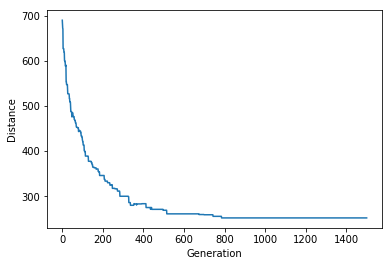

Initial distance: 213.0
Final distance: 77.0
The best route for minimizing completion time is 
[36, 1, 25, 37, 45, 41, 35, 27, 32, 13, 8, 52, 15, 4, 26, 22, 34, 47, 23, 19, 10, 40, 53, 3, 12, 39, 46, 20, 43, 29, 18, 33, 44, 9, 51, 11, 49, 2, 5, 38, 31, 7, 54, 30, 6, 24, 21, 48, 17, 28, 50, 42, 14, 16]




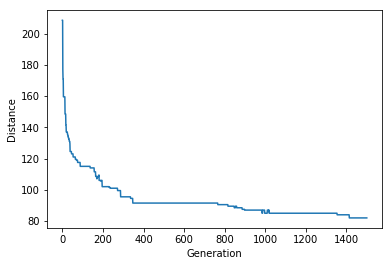

In [41]:
popSize=150
routeLength=n+m-1
Lambda=1
eliteSize=20
mutationRate=0.0005
generations=1500


bestRoute=geneticAlgorithm(popSize, routeLength, CostMatrix, m, Lambda, eliteSize, mutationRate, generations)

print("The best route for minimizing total cost is \n" + str(bestRoute))
print("\n")

geneticAlgorithmPlot(routeLength, popSize, CostMatrix, m, Lambda, eliteSize, mutationRate, generations)

Lambda=0

bestRoute=geneticAlgorithm(popSize, routeLength, CostMatrix, m, Lambda, eliteSize, mutationRate, generations)

print("The best route for minimizing completion time is \n" + str(bestRoute))
print("\n")

geneticAlgorithmPlot(routeLength, popSize, CostMatrix, m, Lambda, eliteSize, mutationRate, generations)
